# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [4]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
pd.set_option('display.max_rows', 50)

In [6]:
pd.set_option('display.max_columns', None)

### 데이터 읽어오기


In [7]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv("data/train.csv")
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Z Unit Time_Dam,CURE END POSITION Z Judge Value_Dam,CURE END POSITION Θ Collect Result_Dam,CURE END POSITION Θ Unit Time_Dam,CURE END POSITION Θ Judge Value_Dam,CURE SPEED Collect Result_Dam,CURE SPEED Unit Time_Dam,CURE SPEED Judge Value_Dam,CURE STANDBY POSITION X Collect Result_Dam,CURE STANDBY POSITION X Unit Time_Dam,CURE STANDBY POSITION X Judge Value_Dam,CURE STANDBY POSITION Z Collect Result_Dam,CURE STANDBY POSITION Z Unit Time_Dam,CURE STANDBY POSITION Z Judge Value_Dam,CURE STANDBY POSITION Θ Collect Result_Dam,CURE STANDBY POSITION Θ Unit Time_Dam,CURE STANDBY POSITION Θ Judge Value_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION X Unit Time_Dam,CURE START POSITION X Judge Value_Dam,CURE START POSITION Z Collect Result_Dam,CURE START POSITION Z Unit Time_Dam,CURE START POSITION Z Judge Value_Dam,CURE START POSITION Θ Collect Result_Dam,CURE START POSITION Θ Unit Time_Dam,CURE START POSITION Θ Judge Value_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED SPEED OF RESIN Unit Time_Dam,DISCHARGED SPEED OF RESIN Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage1) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage2) Judge Value_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Unit Time_Dam,DISCHARGED TIME OF RESIN(Stage3) Judge Value_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage1) Unit Time_Dam,Dispense Volume(Stage1) Judge Value_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage2) Unit Time_Dam,Dispense Volume(Stage2) Judge Value_Dam,Dispense Volume(Stage3) Collect Result_Dam,Dispense Volume(Stage3) Unit Time_Dam,Dispense Volume(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Judge Value_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Unit Time_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Judge Value_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position X Unit Time_Dam,HEAD Standby Position X Judge Value_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Y Unit Time_Dam,HEAD Standby Position Y Judge Value_Dam,HEAD Standby Position Z Collect Result_Dam,HEAD Standby Position Z Unit Time_Dam,HEAD Standby Position Z Judge Value_Dam,Head

### EDA

#### 행 밀린거 복구

In [8]:
train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']=train_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(-999)

train_data=train_data.loc[:,train_data.nunique()>1]

train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace({'OK': np.nan}, inplace=True)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace({'OK': np.nan}, inplace=True)
train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace({'OK': np.nan}, inplace=True)

# THICKNESS 1 Collect Result_Dam 값이 0이 아닌 값들을 식별
mask = train_data['THICKNESS 1 Collect Result_Dam'] != 0

# 밀린 열의 시작점과 끝점 정의
start_cols = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_'
end_cols = 'WorkMode Collect Result_'  # 밀림이 발생한 마지막 열까지의 이름을 넣어야 합니다.

for type in ['Dam', 'Fill1', 'Fill2']:
    start_col=start_cols+type
    end_col=end_cols+type
    # 밀린 열의 인덱스를 찾습니다.
    start_idx = train_data.columns.get_loc(start_col)
    end_idx = train_data.columns.get_loc(end_col) + 1  # 마지막 열 포함

    # 비정상적인 행들에서 밀린 열들만 선택하여 앞으로 이동
    shifted_part = train_data.loc[mask, train_data.columns[start_idx:end_idx]].shift(axis=1, periods=-1)

    # 이동된 값을 원래 데이터프레임에 반영
    train_data.loc[mask, train_data.columns[start_idx:end_idx]] = shifted_part
    
train_data['WorkMode Collect Result_Dam'].fillna(7, inplace=True)
train_data['WorkMode Collect Result_Fill1'].fillna(7, inplace=True)
train_data['WorkMode Collect Result_Fill2'].fillna(0, inplace=True)

In [9]:
train_data

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION Z Collect Result_Dam,CURE END POSITION Θ Collect Result_Dam,CURE SPEED Collect Result_Dam,CURE START POSITION X Collect Result_Dam,CURE START POSITION Θ Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,HEAD Standby Position Y Collect Result_Dam,HEAD Standby Position Z Collect Result_Dam,Head Clean Position X Collect Result_Dam,Head Clean Position Y Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position X Collect Result_Dam,Head Purge Position Y Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position X Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Circle2 Distance Speed Collect Result_Dam,Stage1 Circle3 Distance Speed Collect Result_Dam,Stage1 Circle4 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line2 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage1 Line4 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Circle2 Distance Speed Collect Result_Dam,Stage2 Circle3 Distance Speed Collect Result_Dam,Stage2 Circle4 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage2 Line4 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Circle2 Distance Speed Collect Result_Dam,Stage3 Circle3 Distance Speed Collect Result_Dam,Stage3 Circle4 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line2 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,Stage3 Line4 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,THICKNESS 3 Collect Result_Dam,WorkMode Collect Result_Dam,Model.Suffix_AutoClave,Workorder_AutoClave,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,Equipment_Fill1,Model.Suffix_Fill1,Workorder_Fill1,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage1) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,Dispense Volume(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Coll

In [10]:
train_data=train_data[(train_data['Equipment_Dam'].str[-2:] == train_data['Equipment_Fill1'].str[-2:]) & 
                                 (train_data['Equipment_Dam'].str[-2:] == train_data['Equipment_Fill2'].str[-2:])]

In [11]:
unique_cols = list(train_data.columns)  # 원래 열 순서를 유지하기 위해 리스트로 변환
duplicate_pairs = []  # 중복된 열을 저장할 리스트

for col1 in train_data.columns:
    if col1 in unique_cols:
        for col2 in unique_cols.copy():
            if col1 != col2:
                unique_pairs = train_data[[col1, col2]].drop_duplicates()
                if len(unique_pairs) == train_data[col1].nunique() and train_data[col1].nunique() == train_data[col2].nunique():
                    unique_cols.remove(col2)  # 열 순서를 유지하면서 col2를 제거
                    duplicate_pairs.append((col1, col2))  # 중복된 열 쌍을 추가


# 중복된 열 출력
print("Duplicate columns based on patterns:")
for pair in duplicate_pairs:
    print(f"Column '{pair[1]}' is a duplicate of '{pair[0]}'")

Duplicate columns based on patterns:
Column 'CURE END POSITION X Collect Result_Dam' is a duplicate of 'Equipment_Dam'
Column 'CURE END POSITION Z Collect Result_Dam' is a duplicate of 'Equipment_Dam'
Column 'CURE END POSITION Θ Collect Result_Dam' is a duplicate of 'Equipment_Dam'
Column 'CURE START POSITION X Collect Result_Dam' is a duplicate of 'Equipment_Dam'
Column 'CURE START POSITION Θ Collect Result_Dam' is a duplicate of 'Equipment_Dam'
Column 'Equipment_Fill1' is a duplicate of 'Equipment_Dam'
Column 'Equipment_Fill2' is a duplicate of 'Equipment_Dam'
Column 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2' is a duplicate of 'Equipment_Dam'
Column 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2' is a duplicate of 'Equipment_Dam'
Column 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2' is a duplicate of 'Equipment_Dam'
Column 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2' is a duplicate of 'Equipment_Dam'
Column 'HEAD NORMAL COO

In [12]:
train_data[unique_cols]

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,HEAD Standby Position X Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,target
0,Dam dispenser #1,AJX75334505,4F1XA938-1,100,16,14.9,8.4,14.7,1.04,0.58,1.02,550.5,464.3,161.4,384.0,383.1,384.0,274.51,257.0,124.00,130.85,300.0,265.00,58.5,7.0,127,1,5800,5800,5600,5300,5300,5300,5300,5800,5800,5800,0.000,0.000,0.312,240,0.493,1,0.499,120,54,361,OK,-999,10.6,12.7,3.6,12.6,3.42,838.4,458.7,157.0,430.0,429.8,430.3,244.520,244.520,128,55.7,7.0,127,1,240,33,48,33,835.5,156.0,114.612,19.9,7.0,127,Normal
1,Dam dispenser #1,AJX75334505,3KPM0016-2,70,10,21.3,4.9,21.3,1.49,0.34,1.49,550.3,463.8,160.8,377.3,377.3,377.3,282.15,257.0,130.85,130.85,300.0,265.00,65.1,7.0,185,1,4000,4000

In [13]:
train_data=train_data[unique_cols]

In [14]:
train_data=train_data.loc[:, train_data.nunique()>1]

### 데이터 분할


In [15]:
train_data2=train_data.copy()
train_data2['target']=train_data2['target'].map({'AbNormal':1, 'Normal': 0})

In [16]:
from sklearn.preprocessing import LabelEncoder

features = []
label_encoders = {}

for col in train_data2.columns:
    try:
        train_data2[col] = train_data2[col].astype(int)
        features.append(col)
    except:
        le = LabelEncoder()
        train_data2[col] = le.fit_transform(train_data2[col].astype(str))
        label_encoders[col] = le  # 나중에 복원할 수 있도록 인코더 저장
        features.append(col)

In [37]:
df_train2, df_val = train_test_split(
    train_data2,
    test_size=0.3,
    stratify=train_data["target"],
    random_state=1,
)

#### PCA

In [146]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 타겟 열을 제외한 나머지 데이터를 사용하여 PCA 수행
features = train_data2.drop('target', axis=1)

# 데이터 정규화 (PCA를 수행하기 전에 보통 데이터 표준화를 합니다)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# PCA 수행 (예: 주성분을 2개로 축소)
pca = PCA(n_components=2)  # 원하는 주성분 개수로 n_components 조정
principal_components = pca.fit_transform(scaled_features)

# 결과를 데이터프레임으로 변환
pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])

# 원래의 target 열을 추가
pca_df['target'] = train_data2['target'].values

# 결과 출력
print(pca_df.head())

   Principal Component 1  Principal Component 2  target
0              -1.798726               4.812065       0
1              -0.117886               3.455361       0
2              -5.277782              -1.078570       0
3              -5.887345              -1.568269       0
4               6.216048              -1.462863       0


### 데이터 증강

#### k-means smote

In [86]:
# pip install kmeans-smote

In [87]:
# pip install kmeans_smote/.

In [88]:
from sklearn.preprocessing import LabelEncoder

features = []
label_encoders = {}

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        le = LabelEncoder()
        df_train[col] = le.fit_transform(df_train[col].astype(str))
        label_encoders[col] = le  # 나중에 복원할 수 있도록 인코더 저장
        features.append(col)


In [89]:
from kmeans_smote.kmeans_smote import KMeansSMOTE

X, y = df_train[features].drop('target', axis=1), df_train['target']

[print('Class {} has {} instances'.format(label, count))
 for label, count in zip(*np.unique(y, return_counts=True))]

kmeans_smote = KMeansSMOTE(
    kmeans_args={
        'n_clusters': 2
    },
    smote_args={
        'k_neighbors': 10,
        'sampling_strategy': 0.1
    }
)
X_resampled, y_resampled = kmeans_smote.fit_resample(X, y)

[print('Class {} has {} instances after oversampling'.format(label, count))
 for label, count in zip(*np.unique(y_resampled, return_counts=True))]

Class 0 has 30524 instances
Class 1 has 30524 instances
Class 0 has 30524 instances after oversampling
Class 1 has 30524 instances after oversampling


[None, None]

#### DDHS

In [90]:
from ddhs.ddhs import DDHS
ddhs = DDHS()
X_resampled, y_resampled = ddhs.fit(train_data2.drop('target',axis=1), train_data2[['target']],50,75,1e-3,100,1)

KeyboardInterrupt: 

#### 보더라인

In [18]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2).fit_resample(df_train2.drop('target', axis=1), df_train2['target'])

## 3. 모델 학습


In [123]:
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [20]:
df_concat=pd.concat([X_resampled, y_resampled], axis=1)

In [165]:
# Convert to PyTorch tensors
# X_train=X_resampled.copy()
# Y_train=y_resampled.copy()

X_train, X_test, Y_train, Y_test = train_test_split(scaled_features, train_data2.target, test_size=0.2, random_state=42)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_validation, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_validation.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32)


print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}\n')

print(f'X_validation shape: {X_validation.shape}' )
print(f'Y_validation shape: {Y_validation.shape}\n')

print(f'X_test shape: {X_test.shape}')
print(f'Y_test shape: {Y_test.shape}\n')

X_train shape: (25901, 76)
Y_train shape: (25901,)

X_validation shape: (6476, 76)
Y_validation shape: (6476,)

X_test shape: (8095, 76)
Y_test shape: (8095,)



In [157]:
def find_threshold(model, X_train_tensor):
    with torch.no_grad():
        reconstructions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        reconstruction_errors = torch.mean((reconstructions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        threshold = np.percentile(reconstruction_errors.numpy(), 95)
    return threshold

def predictions(model, X_train_tensor, threshold):
    with torch.no_grad():
        predictions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        errors = torch.mean((predictions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        anomaly_mask = errors > threshold
        preds = anomaly_mask.type(torch.float32)
    return preds.numpy()

In [158]:
def find_threshold(model, X_train_tensor):
    with torch.no_grad():
        reconstructions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        reconstruction_errors = torch.mean((reconstructions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        threshold = np.percentile(reconstruction_errors.numpy(), 95)
    return threshold

def predictions(model, X_train_tensor, threshold):
    with torch.no_grad():
        predictions = model(torch.tensor(X_train_tensor, dtype=torch.float32))
        errors = torch.mean((predictions - torch.tensor(X_train_tensor, dtype=torch.float32)) ** 2, dim=1)
        anomaly_mask = errors > threshold
        preds = anomaly_mask.type(torch.float32)
    return preds.numpy()

In [159]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [160]:
input_dim = X_train.shape[1]
hidden_dim = 128
AE_model = AutoEncoder(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(AE_model.parameters(), lr=0.1)

In [161]:
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

# 학습률 감소 스케줄러 추가
scheduler = StepLR(optimizer, step_size=60, gamma=0.7)  # 10 에포크마다 학습률을 0.1배로 감소

train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []

epochs = 300

for epoch in range(epochs):
    AE_model.train()
    optimizer.zero_grad()

    # Forward pass
    train_reconstruction = AE_model(X_train_tensor)

    # Compute loss
    loss = criterion(train_reconstruction, X_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Calculate and store training metrics
    training_loss = loss.item()
    training_r2_score = r2_score(X_train_tensor.detach().numpy(), train_reconstruction.detach().numpy())

    train_losses.append(training_loss)
    train_accuracies.append(training_r2_score * 100)

    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {training_loss:.4f}, Train Accuracy: {training_r2_score * 100:.3f}%')

    # Validation phase
    AE_model.eval()
    with torch.no_grad():
        output_val = AE_model(X_val_tensor)

        val_loss = criterion(output_val, X_val_tensor).item()
        val_r2_score = r2_score(X_val_tensor.detach().numpy(), output_val.detach().numpy())

    validation_losses.append(val_loss)
    validation_accuracies.append(val_r2_score * 100)

    print(f'\t\tValidation Loss: {val_loss:.4f}, Validation Accuracy: {val_r2_score * 100:.3f}%')

    # 학습률 스케줄러 업데이트
    scheduler.step()

    # 현재 학습률을 출력 (옵션)
    print(f'\t\tLearning Rate: {scheduler.get_last_lr()[0]:.6f}')

# 모델 저장
torch.save(AE_model.state_dict(), "shivanma_assignment2_model_1.pth")

Epoch [1/300], Train Loss: 15.5928, Train Accuracy: -0.283%
		Validation Loss: 256.6795, Validation Accuracy: -2363.894%
		Learning Rate: 0.100000
Epoch [2/300], Train Loss: 259.4752, Train Accuracy: -2435.034%
		Validation Loss: 26450.0352, Validation Accuracy: -230157.196%
		Learning Rate: 0.100000
Epoch [3/300], Train Loss: 26825.6445, Train Accuracy: -236608.640%
		Validation Loss: 193.6825, Validation Accuracy: -1404.496%
		Learning Rate: 0.100000
Epoch [4/300], Train Loss: 195.8660, Train Accuracy: -1433.707%
		Validation Loss: 104.8364, Validation Accuracy: -436.383%
		Learning Rate: 0.100000
Epoch [5/300], Train Loss: 106.2215, Train Accuracy: -432.123%
		Validation Loss: 281.7809, Validation Accuracy: -2566.854%
		Learning Rate: 0.100000
Epoch [6/300], Train Loss: 285.0693, Train Accuracy: -2643.701%
		Validation Loss: 14.6418, Validation Accuracy: 1.615%
		Learning Rate: 0.100000
Epoch [7/300], Train Loss: 14.7658, Train Accuracy: 1.599%
		Validation Loss: 70.0665, Validation

<Figure size 640x480 with 0 Axes>

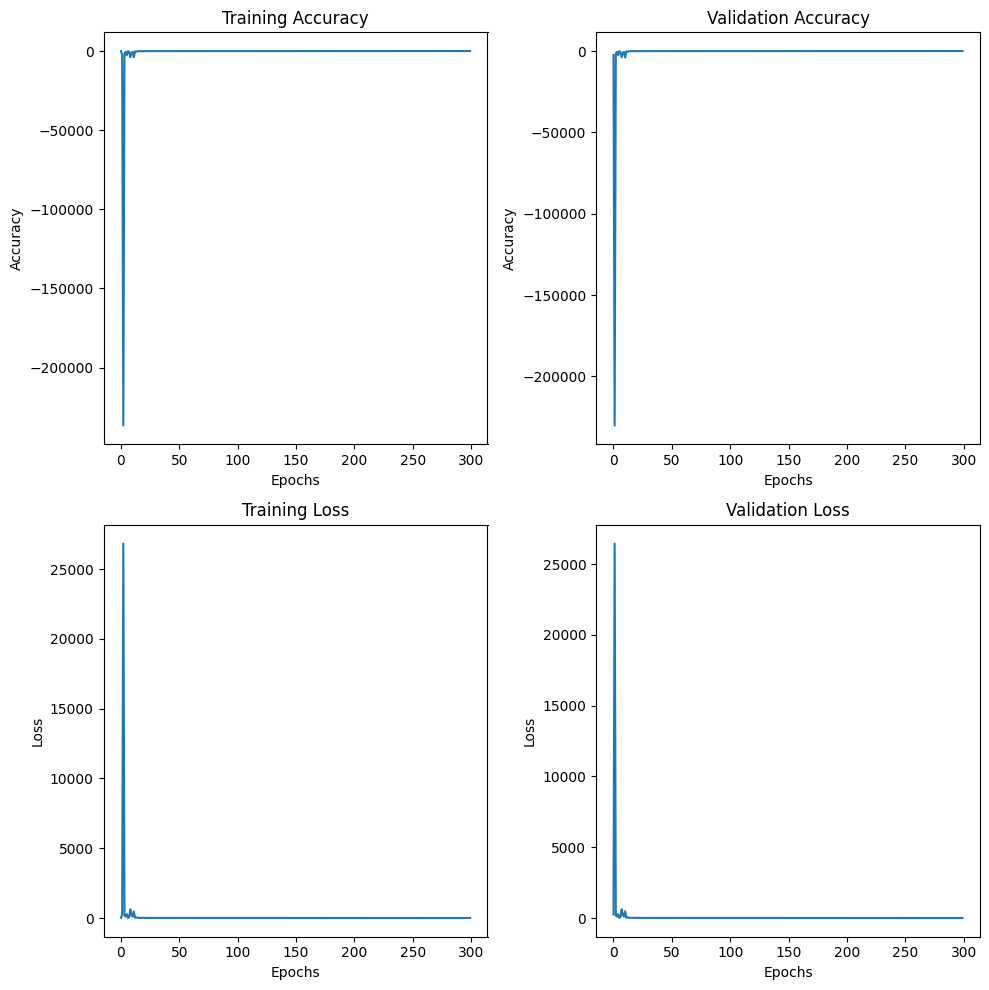

In [162]:
# Plot Training and Validation Accuracy over time (epoch)
plt.figure()
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


# Plot Training and Validation Loss over time (epoch)
plt.subplot(2, 2, 3)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(validation_losses, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [163]:
threshold = find_threshold(AE_model, X_train_tensor)
print(f"Threshold: {threshold}")

Threshold: 27.051177978515625


In [164]:
preds = predictions(AE_model, X_test_tensor, threshold)

# Evaluation
precision_test = precision_score(preds, Y_test_tensor)
recall_test = recall_score(preds, Y_test_tensor)
f1_test = f1_score(preds, Y_test_tensor)
confusion_matrix_test = confusion_matrix(preds, Y_test_tensor)

print(f'Precision: {precision_test:.3f}')
print(f'Recall: {recall_test:.3f}')
print(f'F1 score: {f1_test:.3f}')
print('\nConfusion Matrix: \n', confusion_matrix_test)

Precision: 0.083
Recall: 0.086
F1 score: 0.085

Confusion Matrix: 
 [[7235  420]
 [ 402   38]]


## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [55]:
test_data = pd.read_csv('data/test.csv')

In [56]:
test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave']=test_data['GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave'].fillna(-999)

test_data=test_data.loc[:,test_data.nunique()>1]

test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'].replace({'OK': np.nan}, inplace=True)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'].replace({'OK': np.nan}, inplace=True)
test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'].replace({'OK': np.nan}, inplace=True)

# THICKNESS 1 Collect Result_Dam 값이 0이 아닌 값들을 식별
mask = test_data['THICKNESS 1 Collect Result_Dam'] != 0

# 밀린 열의 시작점과 끝점 정의
start_cols = 'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_'
end_cols = 'WorkMode Collect Result_'  # 밀림이 발생한 마지막 열까지의 이름을 넣어야 합니다.

for type in ['Dam', 'Fill1', 'Fill2']:
    start_col=start_cols+type
    end_col=end_cols+type
    # 밀린 열의 인덱스를 찾습니다.
    start_idx = test_data.columns.get_loc(start_col)
    end_idx = test_data.columns.get_loc(end_col) + 1  # 마지막 열 포함

    # 비정상적인 행들에서 밀린 열들만 선택하여 앞으로 이동
    shifted_part = test_data.loc[mask, test_data.columns[start_idx:end_idx]].shift(axis=1, periods=-1)

    # 이동된 값을 원래 데이터프레임에 반영
    test_data.loc[mask, test_data.columns[start_idx:end_idx]] = shifted_part
    
test_data['WorkMode Collect Result_Dam'].fillna(7, inplace=True)
test_data['WorkMode Collect Result_Fill1'].fillna(7, inplace=True)
test_data['WorkMode Collect Result_Fill2'].fillna(0, inplace=True)

In [57]:
test_data=test_data[unique_cols[:-1]]
test_data=test_data.loc[:,test_data.nunique()>1]

In [58]:
features = []
label_encoders = {}

df_test=test_data

for col in df_test.columns:
    try:
        df_test[col] = df_test[col].astype(int)
        features.append(col)
    except:
        if col=='Set ID':
            continue
        le = LabelEncoder()
        df_test[col] = le.fit_transform(df_test[col].astype(str))
        label_encoders[col] = le  # 나중에 복원할 수 있도록 인코더 저장
        features.append(col)

test_x = df_test[features]

In [60]:
test_x_tensor = torch.tensor(test_x.values, dtype=torch.float32)

In [63]:
test_pred = predictions(AE_model, test_x_tensor, threshold)
test_pred

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [79]:
test_pred[[   64,   562,  1460,  1530,  1892,  2505,  2710,  3457,  3682,  3732,
        4928,  4932,  6092,  7001,  7287,  7666,  7836,  8253,  8898, 10989,
       12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964]]='AbNormal'

In [74]:
df_test=pd.concat([test_data, test_pred], axis=1)

In [77]:
df_test.loc[[   64,   562,  1460,  1530,  1892,  2505,  2710,  3457,  3682,  3732,
        4928,  4932,  6092,  7001,  7287,  7666,  7836,  8253,  8898, 10989,
       12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964], 
       :]

,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,CURE SPEED Collect Result_Dam,DISCHARGED SPEED OF RESIN Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam,Dispense Volume(Stage1) Collect Result_Dam,Dispense Volume(Stage2) Collect Result_Dam,Dispense Volume(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam,Head Clean Position Z Collect Result_Dam,Head Purge Position Z Collect Result_Dam,Head Zero Position Y Collect Result_Dam,Head Zero Position Z Collect Result_Dam,Machine Tact time Collect Result_Dam,PalletID Collect Result_Dam,Production Qty Collect Result_Dam,Receip No Collect Result_Dam,Stage1 Circle1 Distance Speed Collect Result_Dam,Stage1 Line1 Distance Speed Collect Result_Dam,Stage1 Line3 Distance Speed Collect Result_Dam,Stage2 Circle1 Distance Speed Collect Result_Dam,Stage2 Line1 Distance Speed Collect Result_Dam,Stage2 Line2 Distance Speed Collect Result_Dam,Stage2 Line3 Distance Speed Collect Result_Dam,Stage3 Circle1 Distance Speed Collect Result_Dam,Stage3 Line1 Distance Speed Collect Result_Dam,Stage3 Line3 Distance Speed Collect Result_Dam,THICKNESS 1 Collect Result_Dam,THICKNESS 2 Collect Result_Dam,1st Pressure Collect Result_AutoClave,1st Pressure 1st Pressure Unit Time_AutoClave,2nd Pressure Collect Result_AutoClave,2nd Pressure Unit Time_AutoClave,3rd Pressure Collect Result_AutoClave,3rd Pressure Unit Time_AutoClave,Chamber Temp. Collect Result_AutoClave,Chamber Temp. Unit Time_AutoClave,Chamber Temp. Judge Value_AutoClave,GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave,DISCHARGED SPEED OF RESIN Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1,DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1,Dispense Volume(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1,HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1,HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1,Head Purge Position Z Collect Result_Fill1,Machine Tact time Collect Result_Fill1,PalletID Collect Result_Fill1,Production Qty Collect Result_Fill1,Receip No Collect Result_Fill1,CURE END POSITION X Collect Result_Fill2,CURE END POSITION Z Collect Result_Fill2,CURE SPEED Collect Result_Fill2,CURE STANDBY POSITION Z Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2,HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2,Head Purge Position Z Collect Result_Fill2,Machine Tact time Collect Result_Fill2,PalletID Collect Result_Fill2,Production Qty Collect Result_Fill2,0
64,0,0,8,70,10,9,3,9,0,0,0,18,463,160,377,377,377,284,133,133,303,265,92,5,4,1,9000,9000,9000,12000,12000,12000,12000,9000,9000,9000,0,0,0,300,0,60,0,150,50,510,1,0,10,13,4,13,4,6,460,157,430,430,430,244,244,85,90,4,69,1,240,32,51,22,3,156,85,18,4,69,Normal
562,1,0,280,70,10,21,10,21,1,0,1,2,465,552,1271,1270,1271,282,130,130,300,265,72,11,1,1,4000,4000,4000,4000,4000,4000,4000,4000,4000,4000,0,0,0,241,0,121,0,121,52,483,1,0,10,13,3,13,3,9,458,157,430,430,431,244,244,145,77,8,13,1,240,33,50,33,3,156,85,19,8,13,Normal
1460,0,0,83,70,10,9,4,9,0,0,0,18,463,160,377,377,377,284,133,133,300,265,88,5,262,1,9000,9000,9000,9000,9000,9000,9000,9000,

### 제출 파일 작성


In [64]:
test_pred=pd.Series(test_pred).map({0: 'Normal', 1: 'AbNormal'})

In [65]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [66]:
df_sub.target.value_counts()

target
Normal      16474
AbNormal      887
Name: count, dtype: int64

In [88]:
df_sub.target.value_counts()

target
Normal      16446
AbNormal      915
Name: count, dtype: int64

In [80]:
index1=[   64,   562,  1460,  1530,  1892,  2505,  2710,  3457,  3682,  3732,
        4928,  4932,  6092,  7001,  7287,  7666,  7836,  8253,  8898, 10989,
       12439, 12585, 12844, 14756, 15180, 15406, 15811, 15964]

In [86]:
df_sub.loc[index1, 'target'] = 'AbNormal'

In [87]:
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
